In [2]:
import xnat
#xnat.__version__ # 0.3.21
print(f'XNATpy version = {xnat.__version__}') # 0.3.21
import SimpleITK as sitk
import pydicom
import dicom2nifti
import numpy as np
#import math
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import matplotlib.image as mpimg
import os, sys, time
import natsort
import dicom_functions
import explore_dicom_data
from myshow import myshow
import importlib

XNATpy version = 0.3.21


# Connect to XNAT server:

In [3]:
xnatAddress = 'http://10.1.1.17'

session = xnat.connect(xnatAddress, user='admin', password='admin')

# Define the REST path variables:

In [4]:
# Define selected project and subject labels, and session number:
projectLabel = 'BrainTumorProg'
subjectLabel = 'PGM-002'
experimentNo = 0 # (= 1 in XNAT web app; e.g. ‘PGM-002_MR_1’)
scanNo = 0 # 0 -> T1post

# Define the directory to download files from XNAT:

In [27]:
#downloadDir = r'C:\Users\ctorti\Documents\GitHub\WP1.3_multiple_modalities\trying stuff\XNAT downloads'
downloadDir = r'C:\Code\WP1.3_multiple_modalities\trying stuff\XNAT downloads'

# Create a sub-directory for this projectLabel:
newPath = os.path.join(downloadDir, projectLabel)
try:
    os.mkdir(newPath)
    print('Directory', projectLabel, 'created')
except FileExistsError:
    print('Directory', projectLabel, 'already exists')

# Create a sub-directory for this subjectLabel:
newPath = os.path.join(newPath, subjectLabel)
try:
    os.mkdir(newPath)
    print('Directory', subjectLabel, 'created')
except FileExistsError:
    print('Directory', subjectLabel, 'already exists')

# Create a sub-directory for this experimentNo:
newPath = os.path.join(newPath, str(experimentNo))
try:
    os.mkdir(newPath)
    print('Directory', experimentNo, 'created')
except FileExistsError:
    print('Directory', experimentNo, 'already exists')

# Crete a sub-directory for this scanNo:
newPath = os.path.join(newPath, str(scanNo))
try:
    os.mkdir(newPath)
    print('Directory', scanNo, 'created')
except FileExistsError:
    print('Directory', scanNo, 'already exists')
    
    
# Define location for plots to be exported to:
plotsDir = r'C:\Code\WP1.3_multiple_modalities\trying stuff\plots'

Directory BrainTumorProg already exists
Directory PGM-002 already exists
Directory 0 already exists
Directory 0 already exists


# Download the DICOM-RTStruct file to newPath:

In [43]:
# Download the DICOM-RTStruct file to newPath:
ROIobject = session.projects[projectLabel].subjects[subjectLabel].experiments[experimentNo].assessors[scanNo].resources[1]
ROIobject.download_dir(newPath)

157.8 KiB |#                                                      |  78.8 MiB/s


# Download the DICOM scans to newPath:

In [51]:
# Download the DICOM scans to newPath:
session.projects[projectLabel].subjects[subjectLabel].experiments[experimentNo].scans[0].download_dir(newPath)

 11.9 MiB |  #                                                    |  47.7 MiB/s


# Define the paths to the exported DICOM and DICOM-RTStruct files:

In [7]:
# The DICOM files were exported here:
dicomsPath = r'C:\Users\ctorti\Documents\GitHub\WP1.3_multiple_modalities\trying stuff\XNAT downloads\BrainTumorProg\PGM-002\0\0\PGM-002_MR_1\scans\11-T1post\resources\DICOM\files'

# And the ROI DICOM-RTStruct file was exported here:
roiPath = r'C:\Users\ctorti\Documents\GitHub\WP1.3_multiple_modalities\trying stuff\XNAT downloads\BrainTumorProg\PGM-002\0\0\AIM_20200123_145716\out\resources\RTSTRUCT\files'

# Get the filepaths of the DICOM scans:

In [8]:
dicomsFpaths = dicom_functions.dc_filepaths(dicomsPath)
#list(dicomsFpaths)

# Create a dictionary dicomsDict to store the pixel array, image origin, and pixel spacing, using the UIDs as keys:

In [9]:
# Store the UID (as the key), imaging origin, pixel spacing, pixel array and
# "Frame number" (an arbitrary counter starting from 1 to help make things clear):  

dicomsDict = dict()

for f in range(len(dicomsFpaths)):
    fpath = dicomsFpaths[f]
    dicom = pydicom.read_file(fpath)
    sopInstanceUid = dicom.SOPInstanceUID
    origin = np.array(dicom.ImagePositionPatient).astype(np.float)
    pixSpacing = np.array(dicom.PixelSpacing).astype(np.float)
    pixelArray = dicom.pixel_array
    dicomsDict[sopInstanceUid] = {'Frame number':f+1, 'Origin':origin, \
                                  'Pixel spacing':pixSpacing, 'Pixel array':pixelArray}
    
#dicomsDict

# Load the DICOM-RTStruct file:

In [10]:
# Load the DICOM-RTStruct file:
roi = explore_dicom_data.load_dicoms_natsort(roiPath)

# Because the load_dicoms_natsort() function stored the DICOM in a numpy array, need to index the first element:
roi = roi[0]

#roi

# Create a dictionary contoursDict to store the contour data and number of contour points, using the UIDs as keys:

In [11]:
# Since the contour number, number of contour points and the contour data elements are all strings,
# convert the contour number and number of contour points to integers, and store the contour data
# array as a numpy array so it can easily be converted to float:

contoursDict = dict()

for sequence in roi.ROIContourSequence[0].ContourSequence:
    refSopInstanceUid = sequence.ContourImageSequence[0].ReferencedSOPInstanceUID
    contourNo = int(sequence.ContourNumber)
    NcontourPts = int(sequence.NumberOfContourPoints)
    contourData = np.array(sequence.ContourData).astype(np.float)
    
    contoursDict[refSopInstanceUid] = {'Contour number':contourNo, \
                                       'Number of contour points':NcontourPts, 'Contour data':contourData}
    
#contoursDict

# Combine contoursDict and dicomsDict into a new dictionary called dataDict:

In [12]:
Ckeys = list(contoursDict.keys())
Dkeys = list(dicomsDict.keys())

# Create a new dictionary called dataDict that combines both dictionaries. Start by copying dicomsDict:
dataDict = dicomsDict.copy()

for Ckey in Ckeys: # cycle through each key in contoursDict
    ind = Dkeys.index(Ckey) # find index of matching key in dicomsDict
    Dkey = Dkeys[ind] # the matching key in dicomsDict
    
    dataDict[Dkey].update(contoursDict[Ckey]) # update the entry in dataDict for key Dkey with contoursDict

#dataDict

# Create a new array "contourPts" containing the (x,y) image coordinates of each contour point and save it in dataDict:

In [15]:
for uid, values in dataDict.items():
    if not 'Contour data' in values:
        # Add 0 for 'Number of contour points' and [] for 'Contour data' for this uid (key):
        dataDict[uid].update({'Number of contour points':0})
        dataDict[uid].update({'Contour data':[]})
    else: # if 'Contour data' in values:
        #print(values)
        
        origin = values['Origin']
        pixSpacing = values['Pixel spacing']
        NcontourPts = values['Number of contour points']
        contourData = values['Contour data']
        
        # Create an array of (x,y) points from the flattened contour data:
        contourPts = []
        
        x0 = origin[0]
        y0 = origin[1]
        dx = pixSpacing[0]
        dy = pixSpacing[1]
        
        # Iterate for all countour data elements in threes:
        for i in range(0, len(contourData), 3):
            #print('\n', i)
            x = contourData[i]   # x-coordinate in image coords
            y = contourData[i+1] # y-coordinate in image coords
            X = int((x - x0)/dx) # x-coordinate in pix coords
            Y = int((y - y0)/dy) # y-coordinate in pix coords
            
            contourPts.append([X,Y])
            #contourPts.append((X,Y))
            
        # Add contourPts to dictData for this uid (key):
        dataDict[uid].update({'Contour points':contourPts})
            
        #print('\n')
#dataDict

# Plot the DICOM scans with contours overlayed:

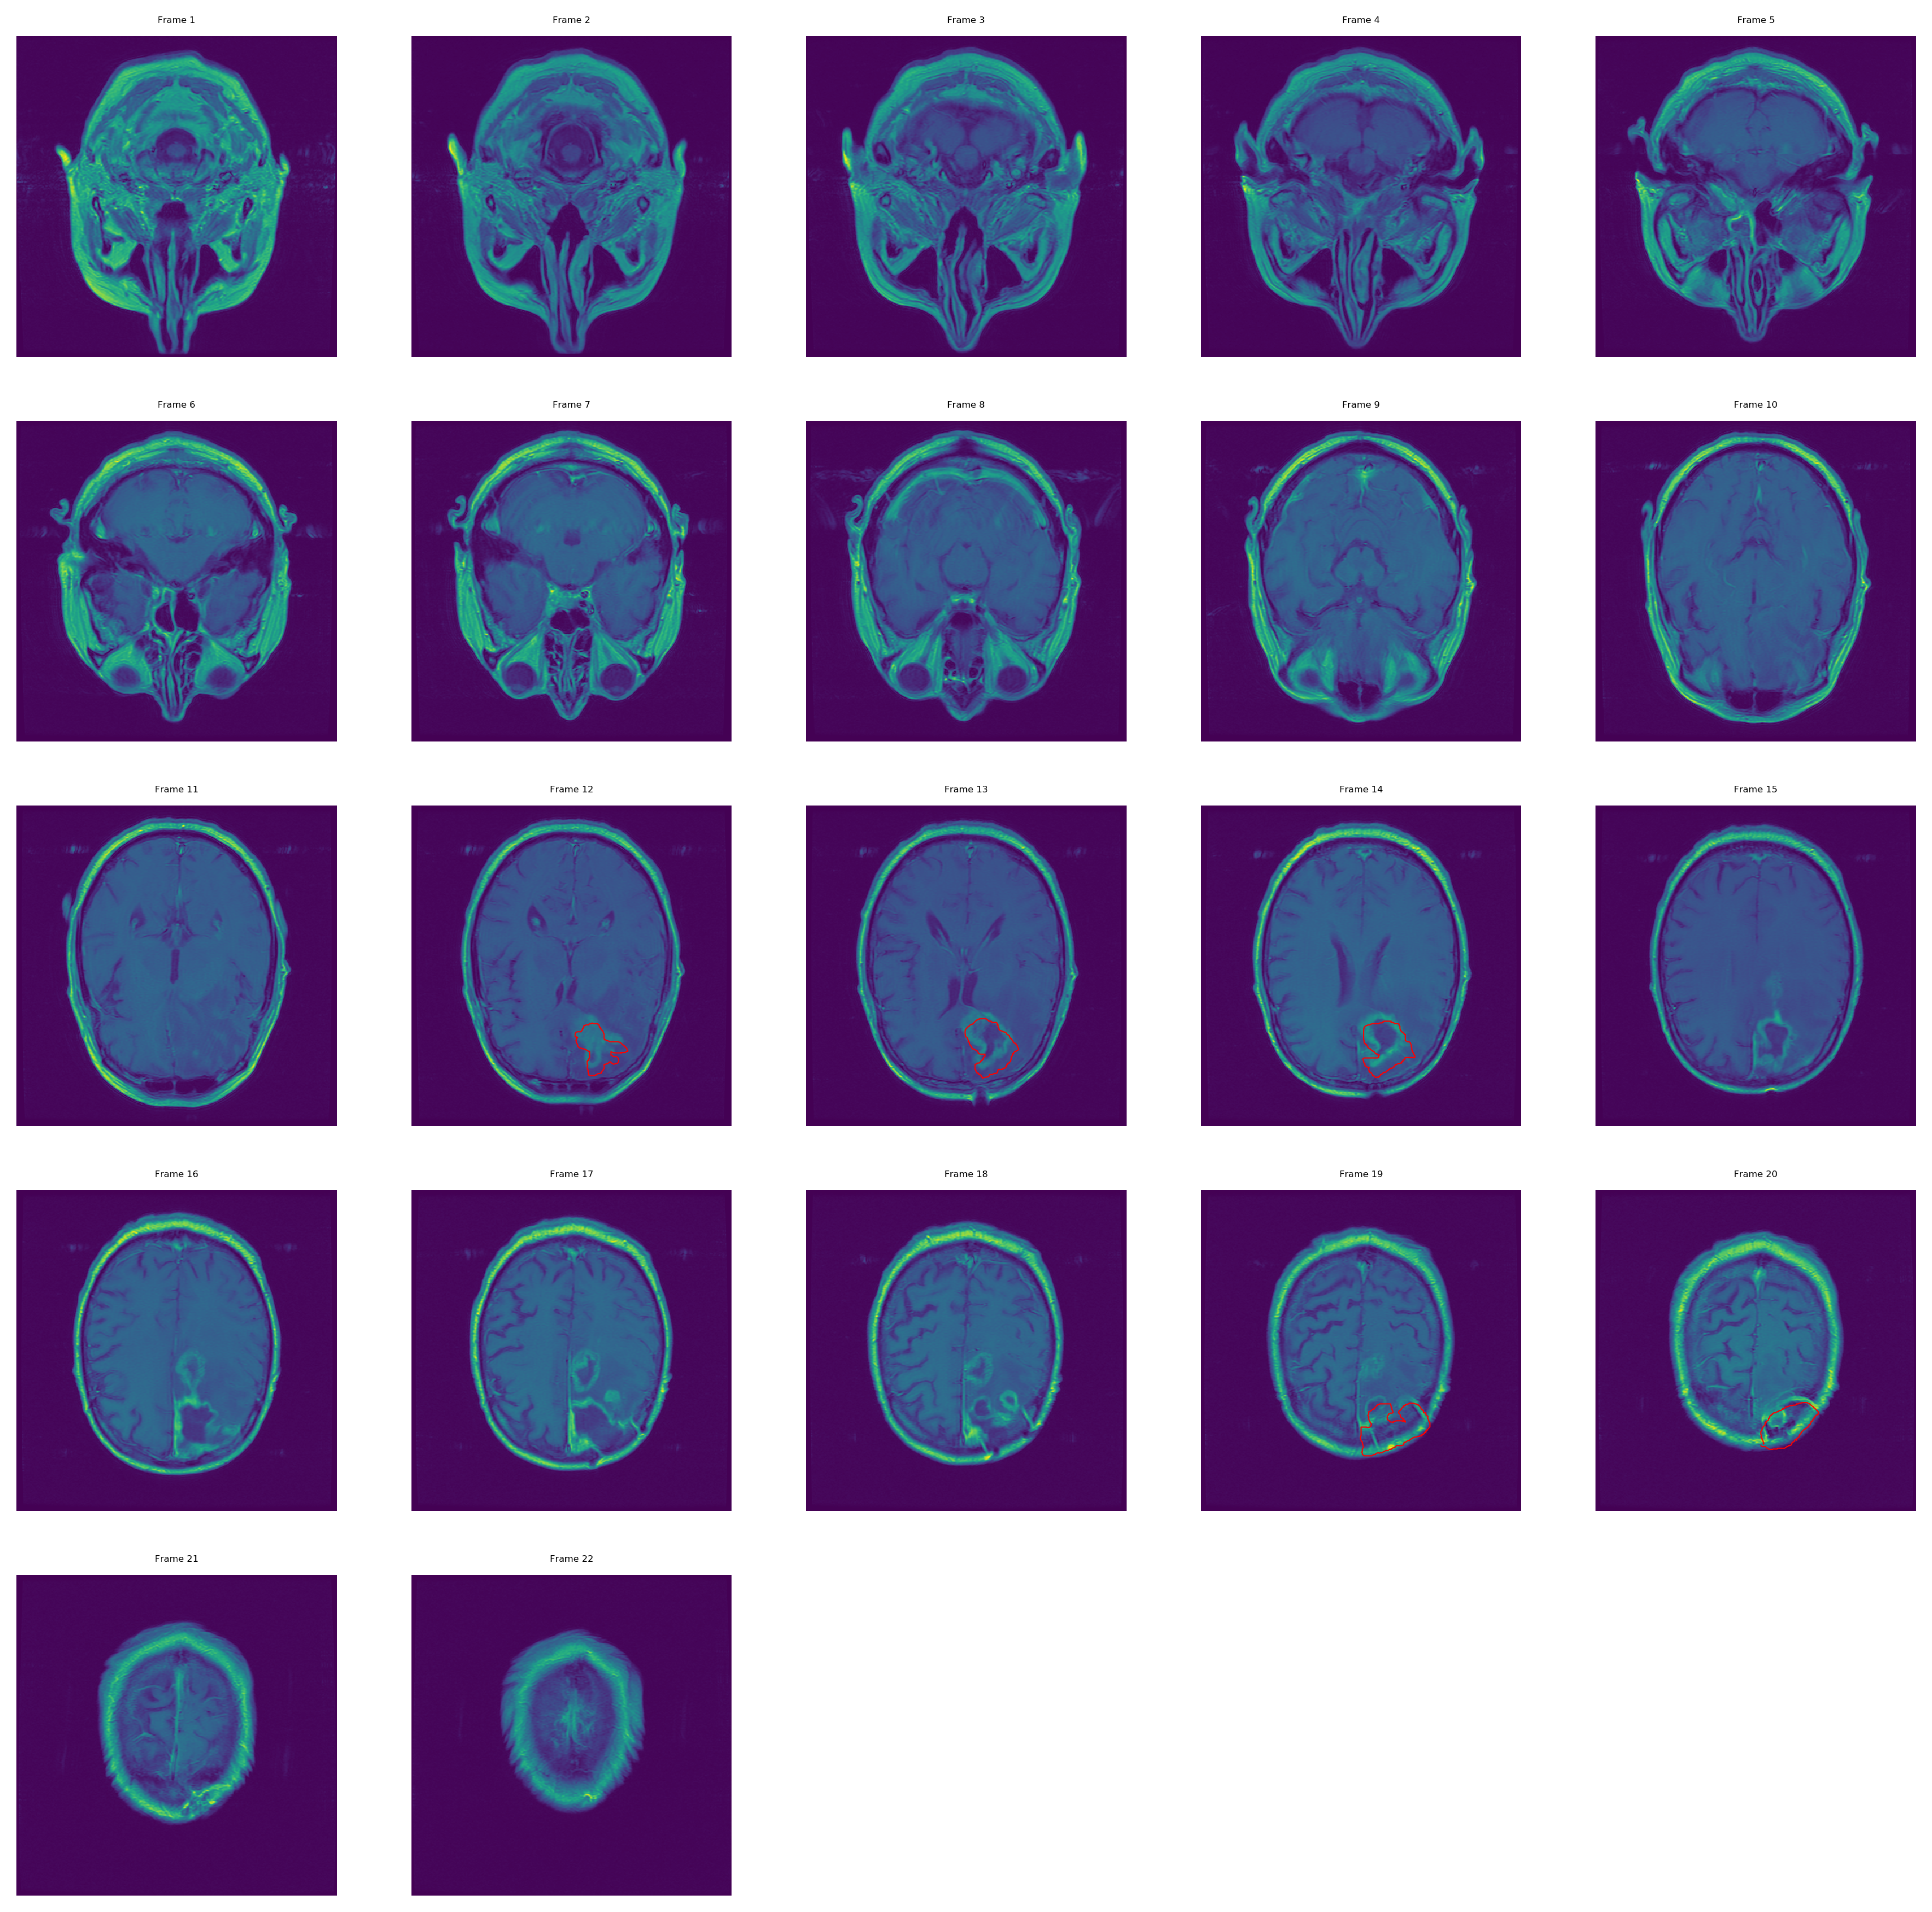

In [51]:
# Configure plot:

# Set the title font:
fontSize=4

Nuids = len(dataDict.keys())

# Set the number of subplot rows and columns:
if 1:
    rows = np.int8(np.round(np.sqrt(Nuids)))
    cols = np.int8(np.round(np.sqrt(Nuids)))
if 0:
    cols = 3
    cols = 2
    rows = np.int8(np.ceil(Nuids/cols))

if cols == 3:
    plt.figure(figsize=(5,15), dpi=300); # cols = 3
elif cols == 2:
    plt.figure(figsize=(5,30), dpi=300); # cols = 2
else:
    plt.figure(figsize=(15,15), dpi=300);

i = 0 # for subplot pos

for uid, values in dataDict.items(): 
    frameNo = values['Frame number']
    pixArray = values['Pixel array']
    
    # Plot:
    i = i + 1    
    plt.subplot(rows,cols,i, aspect='equal')
    plt.pcolormesh(pixArray);
    plt.title(f'Frame {frameNo}', size=fontSize);
    plt.axis('off');
    
    if 'Contour data' in values:       
        contourPts = values['Contour points']
        #print('contourPts =', contourPts, '\n')
        #plt.contour(contourPts); # TypeError: Input z must be at least a 2x2 array.
        #plt.tricontour(contourPts); 
        
        #print('Contour points = ', values['Contour points'], '\n')
        #X, Y = values['Contour points']
        #X, Y = np.array(values['Contour points'])
        
        # Unpack tuple and store each x,y tuple in arrays xList and yList:
        xList = []
        yList = []
        for x, y in contourPts:
            xList.append(x)
            yList.append(y)
        
        # Create a Z array with values 255:
        #zList = np.ones(len(xList))*255
        
        
        # Create 2D arrays for the X and Y values using meshgrid:
        #X, Y = np.meshgrid(xList, yList)
        X = xList[:]
        Y = yList[:]
                
        #print('\nX =', X)
        #print('\nY =', Y, '\n')
        #plt.contour(X, Y, Z);
        
        #plt.scatter(X, Y, s=0.01, c='red');
        plt.plot(X, Y, linewidth=0.5, c='red');


seriesDescription = dicom.SeriesDescription

exportFname = projectLabel + ' ' + subjectLabel + ' ' + seriesDescription \
+ ' All frames with ROIs using XNATpy.jpg'

exportFpath = os.path.join(plotsDir, exportFname)

#plt.savefig(exportFpath, bbox_inches='tight')